# Quantum Neural Networks - Single Feature

A Quantum Neural Network is built for a 2D CFD problem of determining the lift coefficient for varying angles of attack, $\alpha\in[0,15\degree]$. The tutorial below shows for a single feature.

## Install Necessary Libraries

Depending the environment manager, change the first command word to "mamba"/"conda"/"micromamba" for mamba users, miniconda/anaconda users and micromamba users respectively.

In [ ]:
!conda install pandas scipy scikit-learn -c conda-forge -y

## Import Necessary Libraries

In [ ]:
from NoisyCircuits import QuantumCircuit as QC
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from NoisyCircuits.utils.GetNoiseModel import GetNoiseModel
import pickle

2025-08-18 15:03:16,035	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Import and Pre-process Data

In [2]:
data = pd.read_csv("design_study_single_feature.csv", header=0)
X = data.iloc[:,0].values.reshape(-1, 1)
Y = data.iloc[:,-1].values.reshape(-1, 1)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [4]:
x_train = x_train.flatten()
x_test = x_test.flatten()
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
beta_x = np.linalg.norm(x_train)
beta_y = np.linalg.norm(y_train)
x_train = x_train / beta_x
y_train = y_train / beta_y
x_test = x_test / beta_x
y_test = y_test / beta_y

## Initialize Quantum Circuit Instance with Noise

In [ ]:
token = None # Replace with your IBM Quantum token
backend_name = "ibm_brisbane"
num_qubits = 3
num_cores = 50
num_trajectories = 50
threshold = 1e-4
jsonize = True

In [ ]:
# Up-to date noise model
noise_model = GetNoiseModel(backend_name=backend_name, token=token).get_noise_model()
# If API access is not available, load the noise model from a file --> Uncomment the following line
# noise_model = pickle.load(open("Noise_Model_from_Hardware.pkl", "rb"))
nqc = QC(num_qubits=num_qubits, 
         noise_model=noise_model, 
         num_cores=num_cores, 
         num_trajectories=num_trajectories, 
         threshold=threshold, 
         jsonize=jsonize)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-18 15:03:31,590: Default instance not set. Searching all available instances.


Completed Extraction of ECR Errors.
Starting post-processing on Single Qubit Errors.
Completed post-processing on Single Qubit Errors.
Processing ECR errors.
  Qubit pair (0, 1): 5/9 errors above threshold (4 filtered out)
  Qubit pair (1, 2): 18/48 errors above threshold (30 filtered out)
ECR errors processed.
Building Noise Operators for ECR Errors.
Completed building Noise Operators for ECR Errors.
Extracting Measurement Errors.
Available qubits in roerror_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
Reque

2025-08-18 15:03:40,603	INFO worker.py:1927 -- Started a local Ray instance.


## Running the QNN

### Build Quantum Circuit for Quantum Neural Network

Here, the original circuit is modified and the single feature is embedded across $3$ qubits.

In [8]:
def quantum_circuit_pure(weights, x_value):
    # Reset the quantum circuit
    nqc.refresh()
    # Build the trainable layers
    total_layers = len(weights) // 3
    for layers in range(total_layers):
        for q in range(num_qubits):
            nqc.RY(weights[3*layers + q], qubit=q)
        for q in range(num_qubits - 1):
            nqc.CX(control=q, target=q+1)
        for q in range(num_qubits):
            nqc.RX(x_value, qubit=q)
    # Execute the circuit
    probs = nqc.run_pure_state(qubits=range(num_qubits))
    # Obtain the expectation value from the output probability distribution
    exp_val = 0.0
    for i in range(2**num_qubits):
        binary_val = bin(i)[2:].zfill(2**num_qubits)
        exp_val += probs[i] * (1 if binary_val.count("1") % 2 == 0 else -1)
    return exp_val

In [9]:
use_previous_measurement_noise = False
def quantum_circuit_noisy(weights, x_value):
    global use_previous_measurement_noise
    nqc.refresh()
    total_layers = len(weights) // 3
    # Build the trainable layers
    total_layers = len(weights) // 3
    for layers in range(total_layers):
        for q in range(num_qubits):
            nqc.RY(weights[3*layers + q], qubit=q)
        for q in range(num_qubits - 1):
            nqc.CX(control=q, target=q+1)
        for q in range(num_qubits):
            nqc.RX(x_value, qubit=q)
    # Execute circuit
    probs = nqc.execute(qubits=range(num_qubits), num_trajectories=50, use_prev=use_previous_measurement_noise)
    # Update global flag to ensure the measurement noise is re-used after the first instance
    use_previous_measurement_noise = True
    exp_val = 0.0
    for i in range(2**num_qubits):
        binary_val = bin(i)[2:].zfill(2**num_qubits)
        exp_val += probs[i] * (1 if binary_val.count("1") % 2 == 0 else -1)
    return exp_val

### Define Functions

Next we define the functions for predictions, loss function and accuracy functions

In [10]:
def predict(circuit_builder:callable,
            x_array:np.ndarray,
            weights:np.ndarray)->np.ndarray:
    predictions = [circuit_builder(weights, x) for x in x_array]
    return np.array(predictions)

def loss_function(circuit_builder:callable,
                  x_array:np.ndarray=x_train,
                  y_array:np.ndarray=y_train,
                  weights:np.ndarray=None)->float:
    predictions = predict(circuit_builder, x_array, weights)
    cost_mse = np.mean((predictions - y_array) ** 2) * beta_y**2
    return cost_mse

def accuracy_function(circuit_builder:callable,
                      x_array:np.ndarray=x_test,
                      y_array:np.ndarray=y_test,
                      weights:np.ndarray=None)->list[float]:
    predictions = predict(circuit_builder, x_array, weights) * beta_y
    rmse = root_mean_squared_error(y_array*beta_y, predictions)
    r2 = r2_score(y_array*beta_y, predictions)
    return [rmse, r2]

In [11]:
def cost_function(circuit_builder:callable,
                  num_layers:int=1,
                  max_iter:int=100)->tuple[np.ndarray, list, list]:
    cost_list = []
    accuracy_list = []

    def objective(weights:np.ndarray,
                circuit_builder:callable)->float:
        global iteration
        loss = loss_function(circuit_builder, weights=weights)
        accuracy = accuracy_function(circuit_builder, weights=weights)
        iteration += 1
        print(f"Epoch: {iteration}\tLoss: {loss}\tRMSE: {accuracy[0]}\tR2: {accuracy[1]}")
        cost_list.append(loss)
        accuracy_list.append(accuracy)
        return loss
    
    weights_init = np.random.uniform(-2*np.pi, 2*np.pi, size=(num_qubits*num_layers))
    opt = minimize(objective, x0=weights_init,
                   args=(circuit_builder,),
                   method="COBYLA", options={"maxiter": max_iter})
    weights = opt.x
    return (weights, cost_list, accuracy_list)

### Run the QNN with Pure Statevector Simulation

In [12]:
iteration = 0
weights_pure, cost_list_pure, accuracy_list_pure = cost_function(circuit_builder=quantum_circuit_pure,  
                                                                 num_layers=4, 
                                                                 max_iter=100)

Epoch: 1	Loss: 0.8640520864300343	RMSE: 1.1157457387462322	R2: -3.370590887158781
Epoch: 2	Loss: 1.458002964026502	RMSE: 1.3322778886268856	R2: -5.231596466676085
Epoch: 3	Loss: 1.829635230788255	RMSE: 1.6272300179302477	R2: -8.296245335045308
Epoch: 4	Loss: 3.236354768923789	RMSE: 1.9151157934761842	R2: -11.876557092878262
Epoch: 5	Loss: 0.5943499393981589	RMSE: 0.7811679785892323	R2: -1.1423900723424603
Epoch: 6	Loss: 1.1330870290242756	RMSE: 1.0704760532621347	R2: -3.0231256363174417
Epoch: 7	Loss: 2.439828758568835	RMSE: 1.5017092688142955	R2: -6.917378452379648
Epoch: 8	Loss: 0.24550411293049013	RMSE: 0.6178085266753516	R2: -0.34003912314342344
Epoch: 9	Loss: 4.117201903765421	RMSE: 2.0024315540623103	R2: -13.077484006069803
Epoch: 10	Loss: 5.15330395580975	RMSE: 2.2429705404124074	R2: -16.662688965325387
Epoch: 11	Loss: 2.2441410712278596	RMSE: 1.4255250869561051	R2: -6.134432138402217
Epoch: 12	Loss: 0.8085907759811727	RMSE: 1.0855592993313647	R2: -3.1372978380241126
Epoch: 13	L

### Run the QNN with MCWF Method for Noisy Simulation

In [13]:
iteration = 0
weights_noisy, cost_list_noisy, accuracy_list_noisy = cost_function(circuit_builder=quantum_circuit_noisy,
                                                                    num_layers=4,
                                                                    max_iter=100)

Creating Measurement Error Operator for observable qubits: [0, 1, 2]
Measurement Error Operator created.
Executing the circuit with 50 trajectories.
Epoch: 1	Loss: 1.1098289128861516	RMSE: 1.2520167701119078	R2: -4.503385994844265
Epoch: 2	Loss: 0.6505894246361669	RMSE: 0.9420606947437006	R2: -2.1157847739391977
Epoch: 3	Loss: 0.8702241485094827	RMSE: 1.001895399445118	R2: -2.524150501119468
Epoch: 4	Loss: 0.3693147375162652	RMSE: 0.7526438426516646	R2: -0.9887889955425266
Epoch: 5	Loss: 1.180295281528	RMSE: 1.0636865360397838	R2: -2.972253956430864
Epoch: 6	Loss: 1.994752588896055	RMSE: 1.417798323437697	R2: -6.0573003211489524
Epoch: 7	Loss: 1.0534003998213932	RMSE: 0.9886508333471562	R2: -2.431591281093925
Epoch: 8	Loss: 0.18100240395626238	RMSE: 0.5345053881347631	R2: -0.0030298487543962693
Epoch: 9	Loss: 0.1605245507248185	RMSE: 0.4927778743918783	R2: 0.14746526627555134
Epoch: 10	Loss: 1.6875378058203963	RMSE: 1.2577573957843395	R2: -4.553968875174573
Epoch: 11	Loss: 0.3496113077

## Visualize the Results

### Pre-Processing Training and Validation Data

1. Segregate the different metrics for quick and easy visualization.
2. Cap the values of the $R^2$ Score to lie between $[-1,1]$ for clean visualization, where an $R^2$ Score of $-1$. 

In [14]:
accuracy_data_pure = np.array(accuracy_list_pure)
accuracy_data_noisy = np.array(accuracy_list_noisy)
cost_data_pure = np.array(cost_list_pure)
cost_data_noisy = np.array(cost_list_noisy)
rmse_pure = accuracy_data_pure[:,0]
rmse_noisy = accuracy_data_noisy[:,0]
r2_score_pure = accuracy_data_pure[:,1]
r2_score_noisy = accuracy_data_noisy[:,1]
r2_score_pure_filtered = np.clip(r2_score_pure, -1, 1)
r2_score_noisy_filtered = np.clip(r2_score_noisy, -1, 1)
epoch_list = np.arange(1, 101, 1, dtype=int)

### Visualize the Data

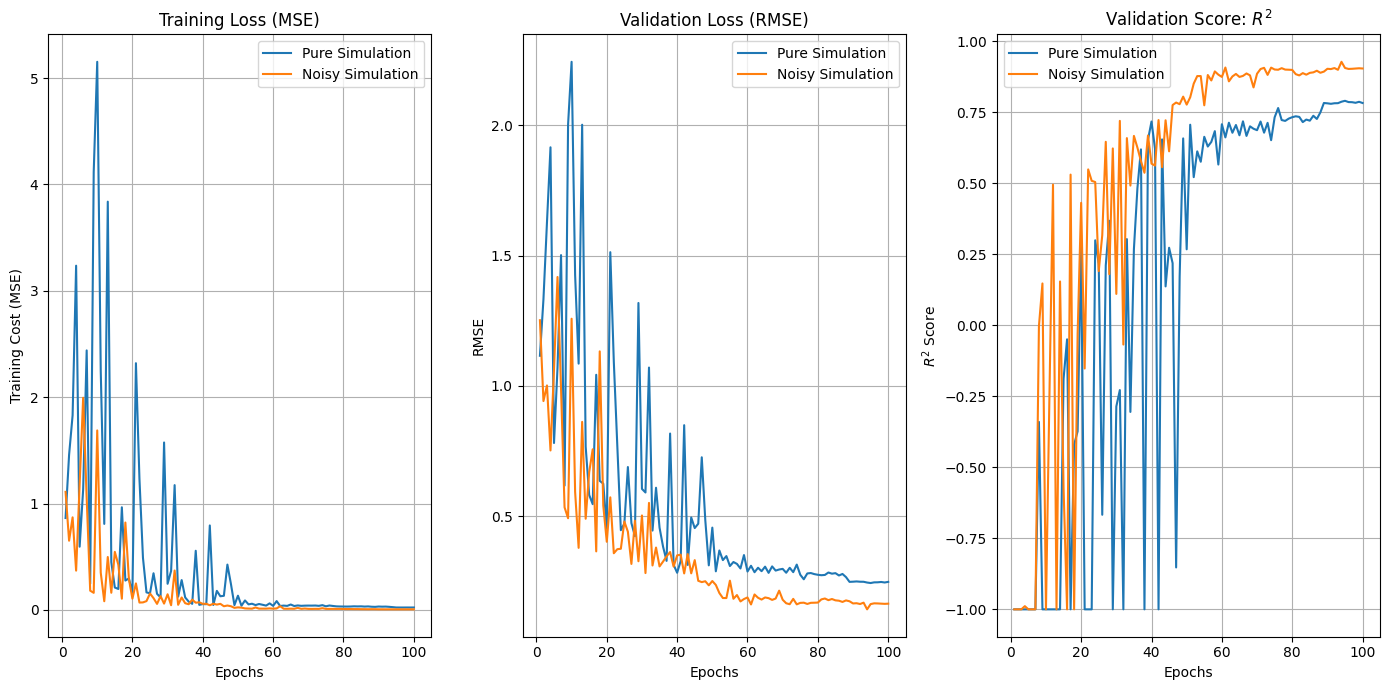

In [27]:
fig, ax = plt.subplots(1,3, figsize=(14,7))
for i, metric in enumerate(zip([cost_data_pure, rmse_pure, r2_score_pure_filtered], [cost_data_noisy, rmse_noisy, r2_score_noisy_filtered])):
    ax[i].plot(epoch_list, metric[0], label="Pure Simulation")
    ax[i].plot(epoch_list, metric[1], label="Noisy Simulation")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(["Training Cost (MSE)", "RMSE", "$R^2$ Score"][i])
    ax[i].set_title(["Training Loss (MSE)", "Validation Loss (RMSE)", "Validation Score: $R^2$"][i])
    ax[i].legend()
    ax[i].grid()
plt.tight_layout()
plt.show()

## Shutdown Parallel Initialization

In [28]:
nqc.shutdown()